https://www.youtube.com/watch?v=Wqmtf9SA_kk

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import warnings
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
path = "../nybolig-scrape/"
data = pd.read_csv(path+"nybolig_data.csv")
postal_codes = (1000, 2900)
data = data[(data['postal_code'] >= postal_codes[0]) & (data['postal_code'] <= postal_codes[1])]

#Count the number of types 
data = data[(data['type'] == 'ejerlejlighed')]

display(data['type'].value_counts())
display(data.head())
display(data.info())

type
ejerlejlighed    282
Name: count, dtype: int64

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label
0,https://www.nybolig.dk/ejerlejlighed/2300/amag...,Amagerfælledvej 138 2. tv 2300 København S,2300,ejerlejlighed,3995000,89,NaN,3,2018,NaN,A2015
1,https://www.nybolig.dk/ejerlejlighed/2800/ulri...,Ulrikkenborg Alle 22 1. tv 2800 Kongens Lyngby,2800,ejerlejlighed,2325000,54,NaN,2,1934,NaN,D
2,https://www.nybolig.dk/ejerlejlighed/2630/save...,Saven B 4 3. 3 Høje Taastrup 2630 Taastrup,2630,ejerlejlighed,2195000,99,NaN,4,1974,NaN,C
3,https://www.nybolig.dk/ejerlejlighed/2000/fins...,Finsensvej 11C 6. tv 2000 Frederiksberg,2000,ejerlejlighed,7995000,126,NaN,5,1969,NaN,D
4,https://www.nybolig.dk/ejerlejlighed/1799/fade...,Fadet 6 33. 4 1799 København V,1799,ejerlejlighed,10200000,118,NaN,4,2022,NaN,A2015


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            282 non-null    object 
 1   address        282 non-null    object 
 2   postal_code    282 non-null    int64  
 3   type           282 non-null    object 
 4   price          282 non-null    int64  
 5   size           282 non-null    int64  
 6   basement_size  0 non-null      float64
 7   rooms          282 non-null    int64  
 8   year_built     282 non-null    int64  
 9   year_rebuilt   34 non-null     float64
 10  energy_label   275 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 24.4+ KB


None

In [33]:
from utils import *
from img_utils import data_to_DF
path = "../nybolig-scrape/output"
data = data_to_DF(path, max_houses=1000)

[ WARN:0@473.411] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@473.412] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@473.529] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@473.549] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@473.717] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@473.753] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@474.246] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@474.392] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@474.628] global loadsave.cpp:244 findDecoder imread_(''): can't open/re

In [34]:
#print columns of path 
print(data.columns)

Index(['address', 'postal_code', 'type', 'price', 'size', 'basement_size',
       'rooms', 'year_built', 'year_rebuilt', 'energy_label',
       'image_floorplan'],
      dtype='object')


# Data Exploration

In [35]:
from sklearn.model_selection import train_test_split
data = data.drop('image_floorplan', axis=1)
X = data.drop(['price'], axis = 1)
y = data['price']

In [36]:
data = data[(data['postal_code'] >= 1000) & (data['postal_code'] <= 2920)]

# set the data to only "ejerlejlighed" on its type
data = data[data['type'] == 'ejerlejlighed']

len(data)

770

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'size'}>,
        <Axes: title={'center': 'rooms'}>],
       [<Axes: title={'center': 'year_built'}>,
        <Axes: title={'center': 'year_rebuilt'}>]], dtype=object)

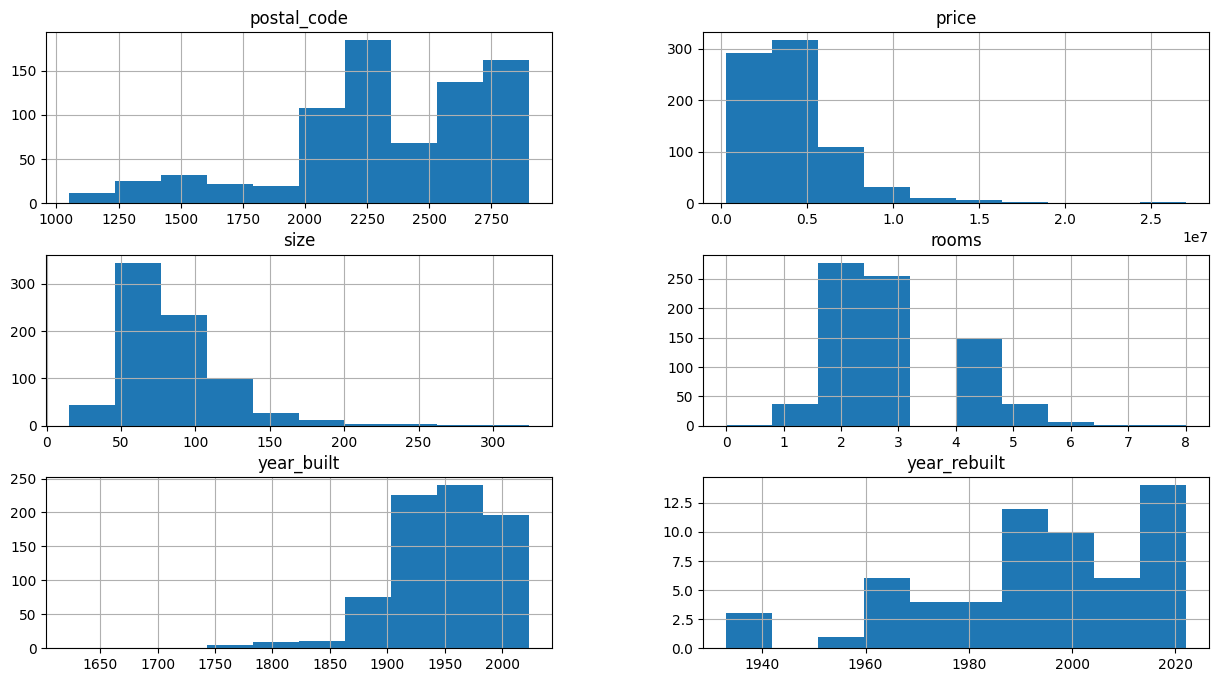

In [37]:
data.hist(figsize = (15, 8))

<Axes: >

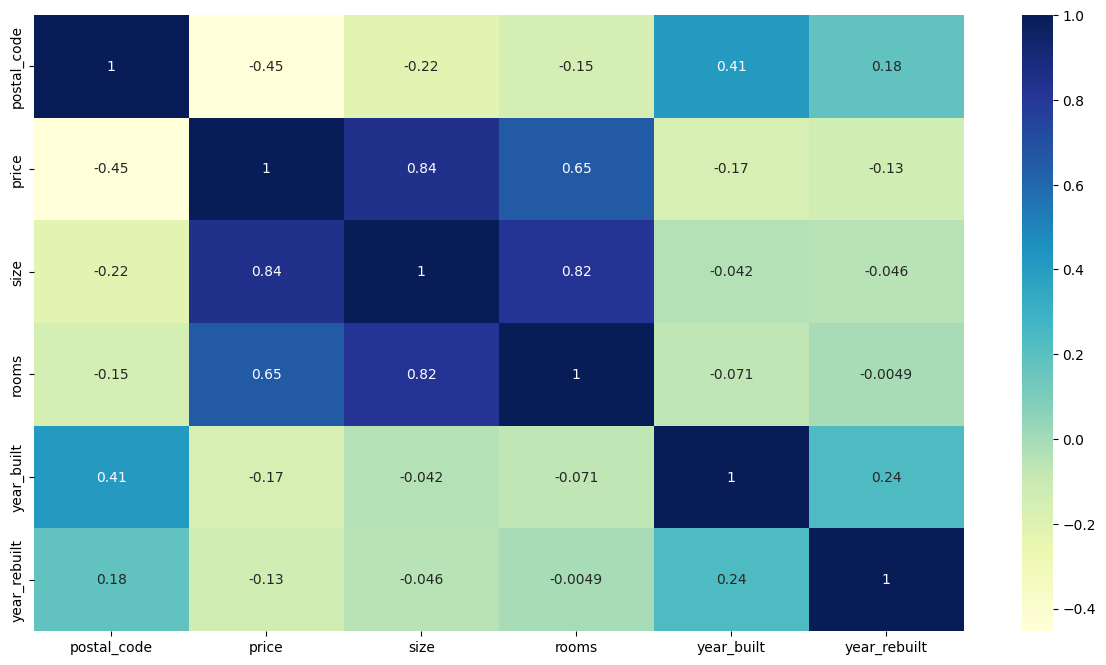

In [38]:
plt.figure(figsize = (15, 8))
sns.heatmap(data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

# Preprocessing

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [40]:
from geopy.geocoders import Nominatim
import re

loc = Nominatim(user_agent = "GetLoc")
def get_lat_long(addresses): 
    #Get the latitude and longitude of the address
    long, lat = [], []
    for address in addresses:
        match = re.search(r"(.*?)\d", address)
        address = match.group(1)
        locations = loc.geocode(address, exactly_one = False)
        #Select location from location that is clostest to (55, 12)
        location = min(locations, key = lambda loc: (loc.latitude - 55)**2 + (loc.longitude - 12)**2)

        #Verify that the location is within (54,12) and (56, 13)
        if location.latitude < 54 or location.latitude > 56 or location.longitude < 12 or location.longitude > 13:
            long.append(None)
            lat.append(None)
        else:
            long.append(location.longitude)
            lat.append(location.latitude)
    return lat, long

def transformation(data):
    data['postal_code'] = (data['postal_code'] + 1) ** 2
    data['rooms'] = np.log(data['rooms'] + 1)
    data['size'] = np.log(data['size'] + 1)
    data['basement_size'] = np.log(data['basement_size'] + 1)
    data['year_built'] = (data['year_built'] + 1) ** 2
    data['year_rebuilt'] = (data['year_rebuilt'] + 1) ** 2
    return data

def encode(data, encoding = 'normal'):
    if encoding == 'normal':
        data['type'] = data['type'].astype('category').cat.codes
        data['energy_label'] = data['energy_label'].astype('category').cat.codes
        data['postal_code'] = data['postal_code'].astype('category').cat.codes
    elif encoding == 'onehot':
        data = pd.get_dummies(data, columns = ['type', 'energy_label', "postal_code"], drop_first = True, dtype=int)
    else:
        raise ValueError("The encoding parameter must be either 'normal' or 'onehot'")
    return data

def drop_low_corr_(data):
    for column in data.select_dtypes(include = np.number).columns:
        if abs(data[column].corr(data['price'])) < 0.1:
            data = data.drop(column, axis = 1)
    return data

def preprocess_data(data, 
                    transformations: bool = False, 
                    encoding: str = 'normal', 
                    drop_low_corr: bool = False,
                    long_lat: bool = False):
    # Fill the missing values
    #remove if year_built is missing
    data['year_rebuilt'] = data['year_rebuilt'].where(~data['year_rebuilt'].isna(), data['year_built']).astype(int)
    data['basement_size'] = data["basement_size"].fillna(0)

    #Set the longitude and latitude
    if long_lat:
        data['latitude'], data['longitude'] = get_lat_long(data['address'])
        

    # Apply the transformations
    if transformations:
        data = transformation(data)
        
    #Set label as above or below mean: 
    mean = data['price'].mean()
    data['above_mean'] = data['price'].apply(lambda x: 1 if x > mean else 0)
    
    # Apply the encoding
    data = encode(data, encoding)

    # Drop the columns that have low correlation with the target variable
    if drop_low_corr:
        drop_low_corr_(data)
        
    # Drop the columns that are not needed
    data = data.drop(['url', 'address'], axis = 1)

    return data

In [41]:
preprocessed_data = prepare_features(data)
#preprocessed_data = preprocess_data(data, transformations = False, encoding = 'normal', drop_low_corr = True, long_lat = False)

<Axes: >

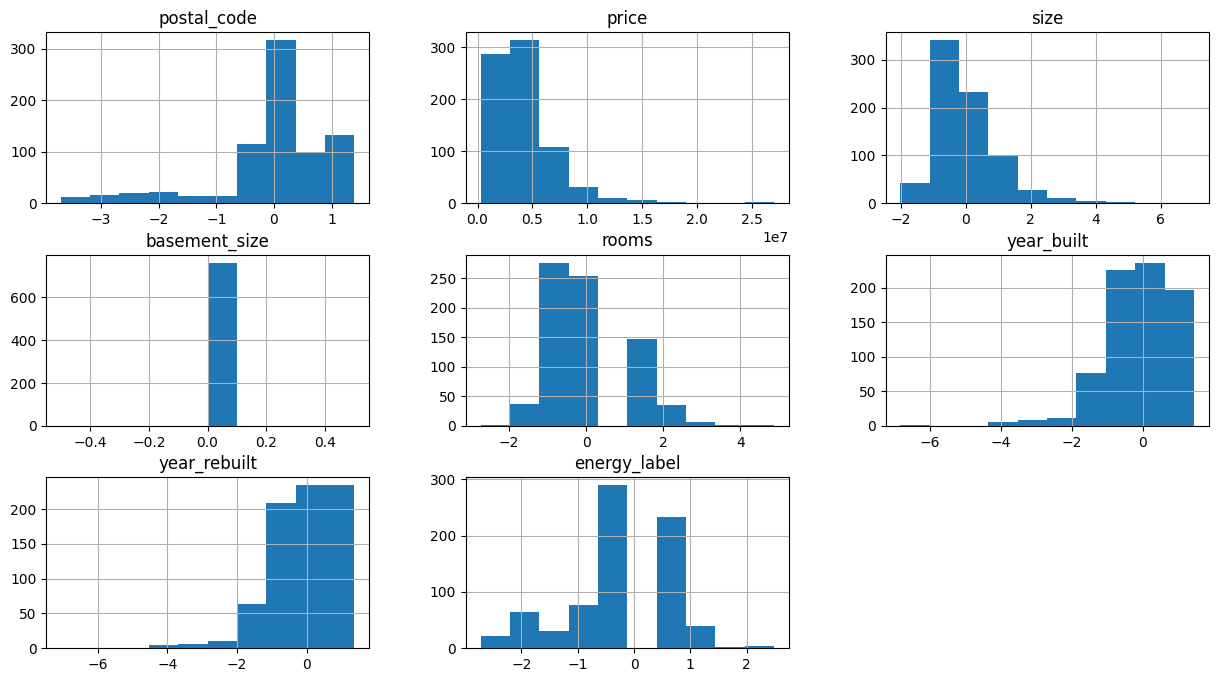

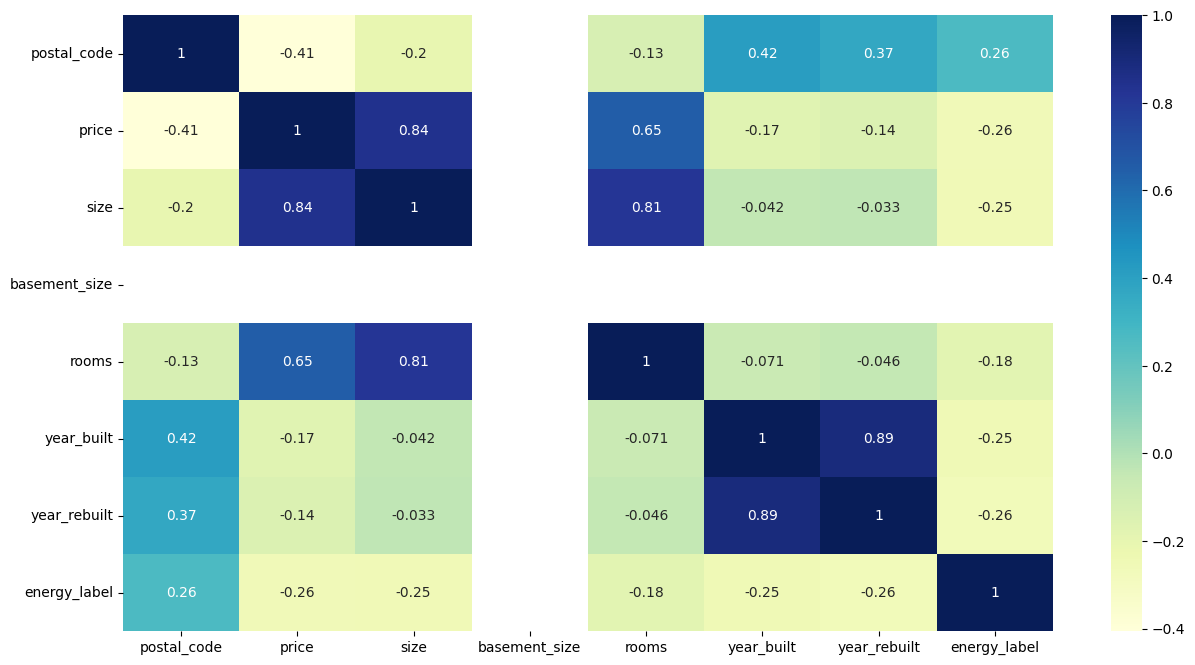

In [42]:
preprocessed_data.hist(figsize = (15, 8))
plt.figure(figsize = (15, 8))
sns.heatmap(preprocessed_data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

#  Price Regression 

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data.drop(['price'], axis = 1), preprocessed_data['price'], test_size = 0.2, random_state = 0)
display(X_train)
display(y_train)

,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label
120,-1.293044,-1.103730,0.0,-1.781764,0.372925,0.269965,-0.118440
245,0.923480,0.065725,0.0,0.119115,-0.413505,1.006720,0.923833
200,-0.019721,-1.162203,0.0,-1.781764,0.352230,0.248915,-0.118440
225,1.253601,-0.021984,0.0,0.119115,0.083188,-0.024737,1.444969
305,0.121759,0.182670,0.0,0.119115,0.310839,0.206814,0.923833
...,...,...,...,...,...,...,...
715,0.074599,-0.197402,0.0,0.119115,-0.434200,-0.550991,0.923833
194,0.121759,-0.723657,0.0,0.119115,-0.103072,-0.214189,-0.118440
636,-0.019721,0.562743,0.0,-1.781764,1.076573,0.985670,-0.639577
565,0.074599,-1.016021,0.0,-0.831324,-0.392809,-0.508891,-0.118440


120    2649000
245    2995000
200    2495000
225    2395000
305    2795000
        ...   
715    3795000
194    2195000
636    3895000
565    2245000
692    6495000
Name: price, Length: 608, dtype: int64

## Linear, Lasso and Ridge Regression 

In [44]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(suppress=True)

Scores [0.71867656 0.75709775 0.85137782 0.67323287 0.73273429]
Test score:  0.8359892673490963

Coefficients: 
postal_code: -541940.1757753402
size: 2369749.4006268163
basement_size: -7.654307410120964e-09
rooms: -247403.17583270615
year_built: -140918.05983352195
year_rebuilt: 11613.615067425417
energy_label: -71446.02573127195

Intercept:  4204124.0158245405

Evaluation
Mean squared error:  1267158401086.0537
Mean absolute error:  818508.0168159934
R2 score:  0.8359892673490963


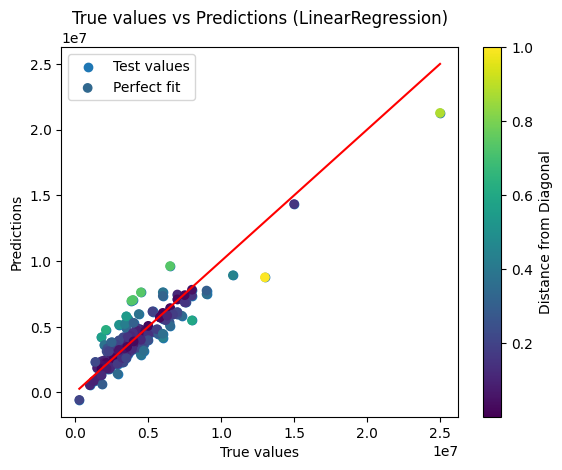

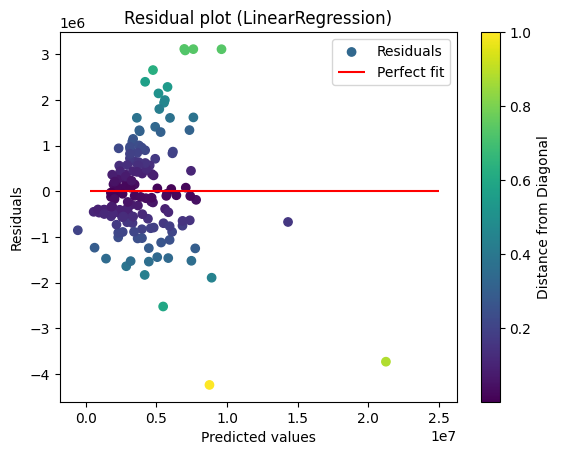

Scores [0.71961558 0.76309915 0.84693089 0.66850321 0.73632408]
Test score:  0.8348492691756848

Coefficients: 
postal_code: -540987.4826021641
size: 2252911.0871633054
basement_size: 0.0
rooms: -153358.91138306257
year_built: -124535.26344464552
year_rebuilt: -6317.922399047196
energy_label: -84867.57078731219

Intercept:  4203976.075518839

Evaluation
Mean squared error:  1275966106772.8271
Mean absolute error:  816969.5714033324
R2 score:  0.8348492691756848


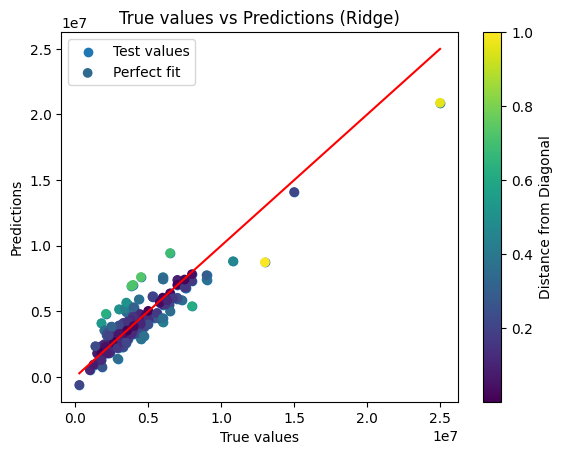

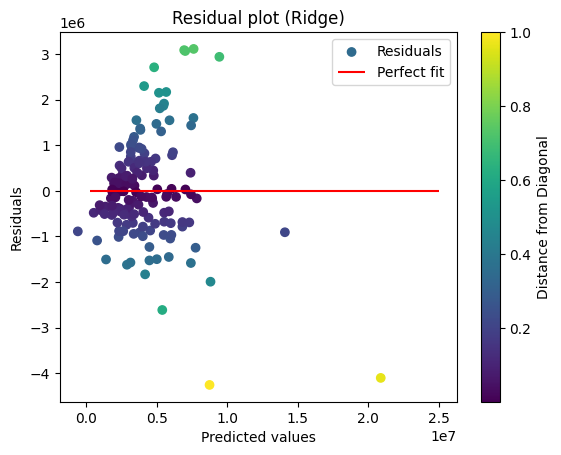

Scores [0.71867483 0.75710115 0.85137726 0.67323363 0.73273454]
Test score:  0.8359897266148049

Coefficients: 
postal_code: -541941.7865173123
size: 2369694.966748638
basement_size: 0.0
rooms: -247345.63482536824
year_built: -140823.85671262833
year_rebuilt: 11522.839850342625
energy_label: -71440.46360596348

Intercept:  4204124.3911036365

Evaluation
Mean squared error:  1267154852767.0417
Mean absolute error:  818508.8017209421
R2 score:  0.8359897266148049


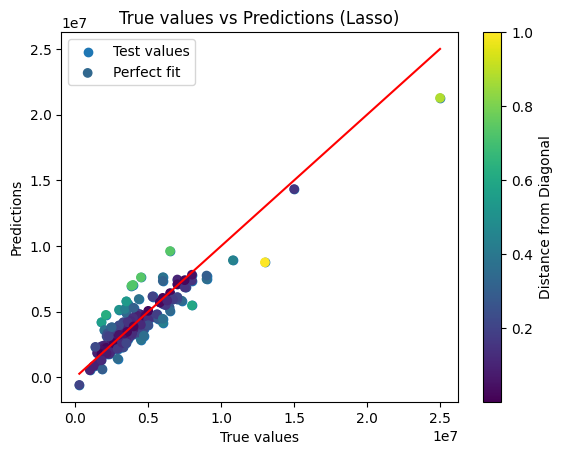

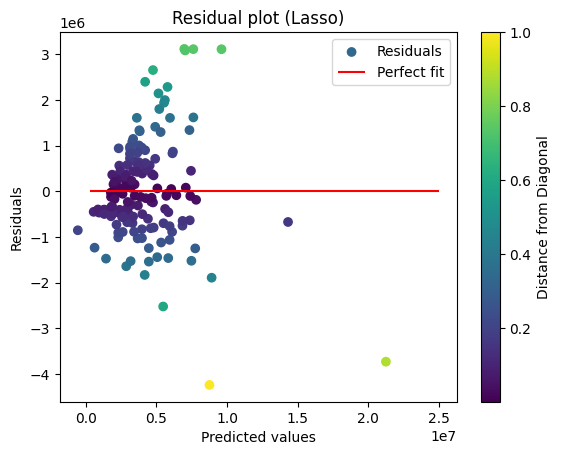

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def regression(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=5)
    print("Scores", score)
    print("Test score: ", model.score(x_test, y_test))
    print("\nCoefficients: ")
    for feature, coef in zip(x_train.columns, model.coef_):
        print(f"{feature}: {coef}")
    print("\nIntercept: ", model.intercept_)

    # Predicting the test set results
    y_pred = model.predict(x_test)
    
    #Evaluating the model
    print("\nEvaluation")
    print("Mean squared error: ", mean_squared_error(y_test, y_pred))
    print("Mean absolute error: ", mean_absolute_error(y_test, y_pred))
    print("R2 score: ", r2_score(y_test, y_pred))

    # Plotting the results
    plot_regression_results(model.__class__.__name__, y_test, y_pred)

linear_model_ = linear_model.LinearRegression()
lasso_model = linear_model.Lasso(alpha = 10)
ridge_model = linear_model.Ridge(alpha = 10)
regression(linear_model_, X_train, y_train, X_test, y_test)
regression(ridge_model, X_train, y_train, X_test, y_test)
regression(lasso_model, X_train, y_train, X_test, y_test)

For this results, we have the following: 
  1. Scores: These are cross-validation scores obtained using 5-fold cross-validation. They represent the R-squared values achieved by the Lasso model on different folds of the training data. Each score corresponds to one fold.
  2. Test score: This is the R-squared score of the model on the held-out test set.
  3. Coefficients: These are the weights assigned to each feature by the  model. 
  4. Intercept: This is the bias term of the model.

## Random Forest 

In [46]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state = 0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Feauture Importance
postal_code 0.1237
size 0.7446
basement_size 0.0
rooms 0.0096
year_built 0.0594
year_rebuilt 0.0497
energy_label 0.013
R2 score:  0.799473579391798
Mean squared error:  1549281162314.2195
Mean absolute error:  645607.3970588235


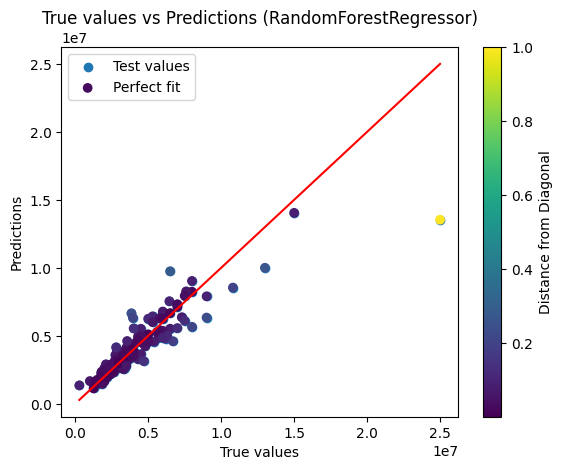

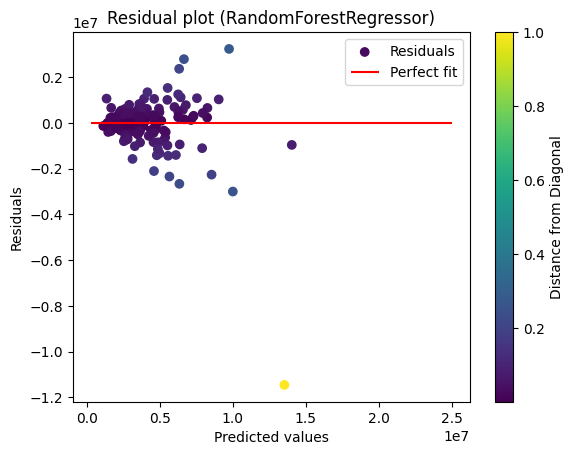

In [47]:
print("Feauture Importance")
for feature, importance in zip(X_train.columns, forest.feature_importances_):
    print((feature), round(importance,4))
print("R2 score: ", forest.score(X_test, y_test))
print("Mean squared error: ", mean_squared_error(y_test, forest.predict(X_test)))
print("Mean absolute error: ", mean_absolute_error(y_test, forest.predict(X_test)))
plot_regression_results(forest.__class__.__name__, y_test, forest.predict(X_test))

### Hyperparameter Tuning

In [48]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'max_features': [3, 4, 5],
# }

# grid_search = GridSearchCV(forest, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, y_train)
# best_forest = grid_search.best_estimator_
# best_forest

In [49]:
# best_forest.score(X_test, y_test)

In [50]:
# print("Best parameters: ", grid_search.best_params_)
# print("R2 score: ", best_forest.score(X_test, y_test))
# print("Mean squared error: ", mean_squared_error(y_test, best_forest.predict(X_test)))
# print("Mean absolute error: ", mean_absolute_error(y_test, best_forest.predict(X_test)))

# plot_regression_results(best_forest.__class__.__name__, y_test, best_forest.predict(X_test))

## Extreme Gradient Boosting 

In [51]:
import xgboost as xgb

R2 score:  0.7474958788818442
Mean squared error:  1950864514853.1904
Mean absolute error:  639283.6756535948


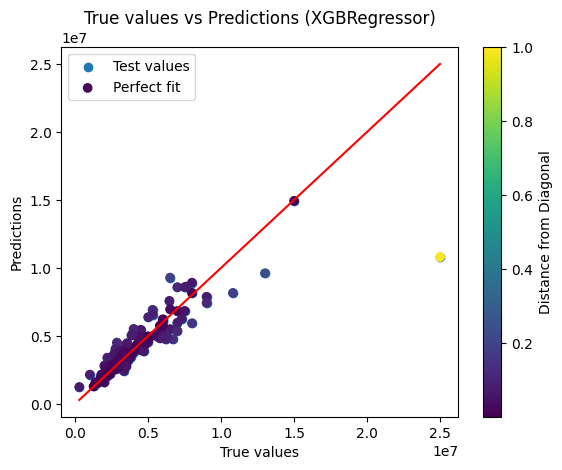

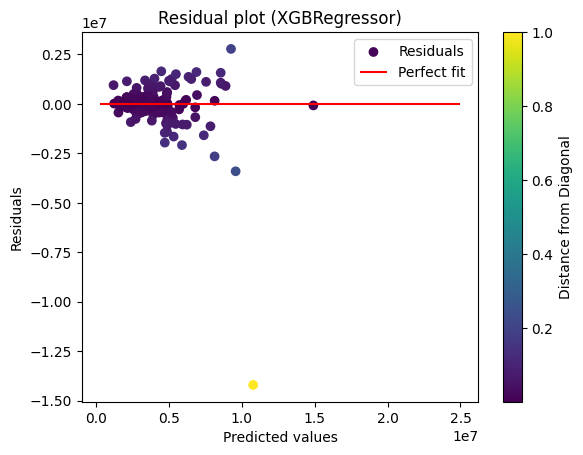

In [52]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
print("R2 score: ", r2_score(y_test, pred))
print("Mean squared error: ", mean_squared_error(y_test, pred))
print("Mean absolute error: ", mean_absolute_error(y_test, pred))

plot_regression_results(xgb_model.__class__.__name__, y_test, pred)

In [53]:
#Save the xgb model
import joblib
joblib.dump(xgb_model, 'trained_models/xgb_model.pkl')

['trained_models/xgb_model.pkl']

## Neural Network Apporach 

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, LogCosh, MeanSquaredLogarithmicError, CosineSimilarity, KLDivergence, Poisson, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, Poisson, KLDivergence, SquaredHinge, Hinge


In [60]:
from utils import regression_stats, plot_regression_results
def neural_network(x_train, y_train, x_test, y_test): 
  #turn y_train and y_test into log(y_train) and log(y_test)
  #y_train = np.log(y_train)
  #y_test = np.log(y_test)
  scale = False 
  if scale: 
    scale = StandardScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)


  model = Sequential()
  #Adding layers 
  num_features = x_train.shape[1]
  model.add(Dense(9, input_dim = num_features, activation = 'relu'))
  model.add(Dense(9, activation = 'relu'))
  model.add(Dense(9, activation = 'relu'))
  model.add(Dense(1, activation = 'linear'))
  #Compiling and fitting 
  model.compile(optimizer = Adam(learning_rate=0.02), 
                loss = "mean_squared_error", 
                metrics = ["mean_absolute_error"])

  model.fit(x_train, 
            y_train, 
            epochs = 250, 
            batch_size = 32, 
            validation_data = (x_test, y_test), 
            callbacks = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True),
            verbose = 0
            )
  
  print("Test score: ", model.evaluate(x_test, y_test))

  y_pred = model.predict(x_test).flatten()  
  #Evaluating the model
  regression_stats(y_test, y_pred)
  plot_regression_results("Neural Network", y_test, y_pred)
  return None

5/5 [==============================] - 0s 2ms/step - loss: 1226233741312.0000 - mean_absolute_error: 784699.0625
Test score:  [1226233741312.0, 784699.0625]
5/5 [==============================] - 0s 2ms/step
R^2: 0.8412862352027927
Mean Absolute Error: 784699.0040849673
Mean Percentage Error: 25.21749899793929
Mean Squared Error: 1226233656664.719


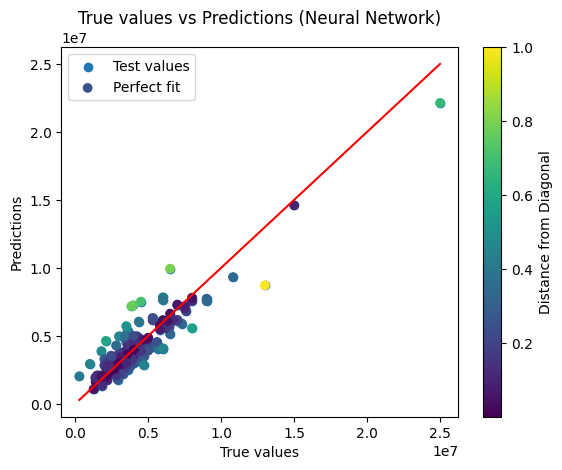

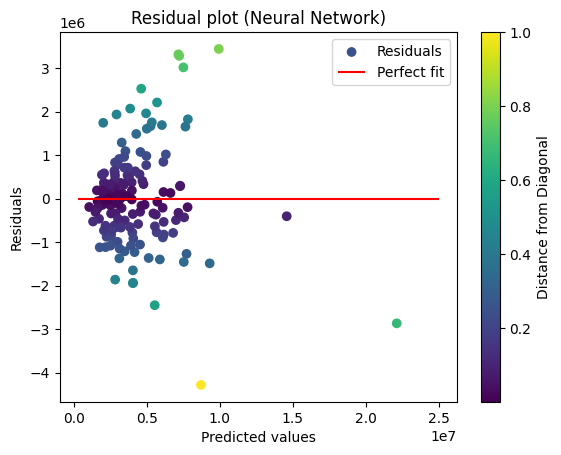

In [61]:
neural_network(X_train, y_train, X_test, y_test)

# Binary Regression

In [57]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(preprocessed_data.drop(['price', 'above_mean'], axis = 1), preprocessed_data['above_mean'], test_size = 0.2, random_state = 0)
display(X_train_binary)
display(y_train_binary)

KeyError: "['above_mean'] not found in axis"

## Random Forrest Binary Regression

In [ ]:
# Do the same for the binary classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gradient_boosting = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

def classification(model, x_train, y_train, x_test, y_test):
    print(model.__class__.__name__)
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=5)
    print("Cross Val Scores", score)
    print("Test score: ", model.score(x_test, y_test))
    print("Accuracy: ", accuracy_score(y_test, model.predict(x_test)))

    return None

classification(gradient_boosting, X_train_binary, y_train_binary, X_test_binary, y_test_binary)
classification(random_forest, X_train_binary, y_train_binary, X_test_binary, y_test_binary)

GradientBoostingClassifier
Cross Val Scores [0.84444444 0.82222222 0.82222222 0.91111111 0.84444444]
Test score:  0.9649122807017544
Accuracy:  0.9649122807017544
RandomForestClassifier
Cross Val Scores [0.84444444 0.82222222 0.77777778 0.88888889 0.77777778]
Test score:  0.9473684210526315
Accuracy:  0.9473684210526315
